In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
import itertools
import datetime
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import sys

C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
class TGIM_Model(object):
    def __init__(self):
        
        #Class constructor or initialization method.''''''
        earth = "blue"
        
    def get_data(self, data):
        #data= pd.read_csv(r"C:\Users\1004365\Desktop\Ajith TCS Internal\TGIM\\CPU_LOAD_OLD.csv")
        data_copy = data.copy()
        print("Top two columns of data set")
        print("\n")
        print(data_copy.head(2))
        print("\n")
        print("\n")
        print("Columns",data_copy.columns)
        
        #convert dataframe into time series
        data_copy['Date'] = pd.to_datetime(data_copy['Date'])
        
        ###################### getting basic statistics  ###############################
        print("The statistical analysis on data set \n")
        print("\n")
        print(data_copy.describe())
        data_copy.index = data_copy['Date']
        data_copy.index =data_copy.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M'))
        data_copy['no_seconds'] = data_copy.index
        #
        data_copy['Day/Month/Year'] = data_copy['Date'].apply(lambda x: "%d/%d/%d" % (x.day,x.month, x.year))
        print("\n")
        print("\n")
        print("The number samples per each day on original data\n")
        print(pd.value_counts(data_copy['Day/Month/Year'], sort = True))
        #
        #create a new time series
        times = pd.date_range('2017-07-16 00:02:00 ', periods=9216, freq='5min')

        times_df = pd.DataFrame()
        times_df["series"] = times
        times_df.index= times_df["series"]
        times_df.index =times_df.index.map(lambda t: t.strftime('%Y-%m-%d %H:%M'))
        times_df['no_seconds'] = times_df.index
        #
        mergerd = pd.merge(times_df, data_copy, on='no_seconds', how= 'outer')
        print("\n")
        print("\n")
        print("Newly merged data frame which contains newly for time stamps")
        print(mergerd.head(3))
        del mergerd['series']
        del mergerd['Day/Month/Year']
        mergerd['no_seconds'] = pd.to_datetime(mergerd['no_seconds'])
        mergerd.index = mergerd.no_seconds
        mergerd = mergerd.sort_index() 
        values = mergerd.groupby(pd.TimeGrouper('5Min'))['Value'].sum()
        #
        print("\n")
        print("\n")
        print("After sorting time indices and wrapping to 5min time stamp")
        print(values.shape)
        train_df = pd.DataFrame()
        train_df['values'] = values
        train_df['Date'] = train_df.index
        train_df['Date'] = pd.to_datetime(train_df['Date'])
        train_df['Day/Month/Year'] = train_df['Date'].apply(lambda x: "%d/%d/%d" % (x.day,x.month, x.year))
        print("\n")
        print("\n")
        print("Now check for missing time stamps, there are no missing timeslots")
        print(pd.value_counts(train_df['Day/Month/Year'], sort = True))
        print("missing values at different times")
        print(train_df.apply(lambda x: sum(x.isnull())))
        y = train_df['values']
        
        print("validity check")
        print(y)
        nan_index = list(y[np.isnan(y.values)].index)

        for dIndex in nan_index:
            upper = dIndex + datetime.timedelta(minutes=5)
            lower = dIndex - datetime.timedelta(minutes=5)
    
            while(np.isnan(y[upper])):
                upper = upper + datetime.timedelta(minutes=5)
            while(np.isnan(y[lower])):
                lower = lower - datetime.timedelta(minutes=5)
            y[dIndex] = (y[upper] + y[lower])/2
        
        #delete un used variables
        del times_df, data_copy, data,mergerd
        Dummy_df = pd.DataFrame(y)
        print("\n")
        print("\n")
        print("Missing values after imputation with average of above and below values")
        print(Dummy_df.apply(lambda x: sum(x.isnull())))
        del Dummy_df
        return y
    #
    #
    def decomposeSeries(self, series, period=288):
        decomposedSeries = sm.tsa.seasonal_decompose(series,freq=period)
        season = decomposedSeries.seasonal
        series_new = series - season
        latest_date = season.index.date[-1]
        season_pre = season[str(latest_date)]
        season_pre.index = season_pre.index + datetime.timedelta(days=1)
        #print("\n")
        #print("\n")
        #print(len(season_pre))
        return series_new,season_pre

    #Dickey Fuller Test of Stationarity-
    def testStationarity(self, series):
        result = adfuller(series)
        print("\n")
        print("\n")
        print("Dickey Fuller Test of Stationarity")
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        print("\n")
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
                            
    def findOrder(self, series, p=5,d=2,q=5):
        p = range(p)
        d = range(d)
        q = range(q)
        orderList = list(itertools.product(p, d, q))
        AIC = []
        minAIC = sys.maxsize
        selOrder = (0,0,0)
        for order in orderList:
            try:
                print("processing order {}".format(order))
                model = ARIMA(series, order=order)
                model_fit = model.fit(disp=0)
                print("Order {} AIC {} BIC {}".format(order,model_fit.aic,model_fit.bic))
                AIC.append(model_fit.aic)
                if(model_fit.aic < minAIC):
                    minAIC = model_fit.aic
                    selOrder = order
            except:
                continue
        return selOrder

    def doArima(self, series,order):
        model = ARIMA(series, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        return np.squeeze(yhat)
     
    def forecast_plot(self, y_decomp,y, season,order):
        for i in range(1):  
            train_size = int(len(y) - 288 + i*12)
            y_new = y_decomp.copy()
            y_new = y_new.append((y[len(y_decomp):train_size] - season).dropna())
            test = y[train_size:train_size+30]
            #print(y_new[-1])
            history = [x for x in y_new]
            predictions = list()
            for t in range(30):
                print("\n")
                print(t)
                yhat = self.doArima(history,order)
                predictions.append(yhat)
                history.append(yhat)
                print("Predicted : {} Actual:{}".format(np.round(np.squeeze(yhat),2)+np.round(season[t+i*12],2),np.round(test[t],2)))

            test_act = test[:30]
            test_pre = pd.Series(np.squeeze(predictions),index = test_act.index) + season[i*12:i*12+30]
            print("season")
            print(season[i*12:i*12+30])
            print("\n")
            print("Actual", test_act)
            print("\n")
            print("Predicted", test_pre)
            print("\n")
            plt.plot(test_act)
            plt.plot(test_pre)
            plt.legend(["Actuals","Predicted"])
            plt.xlabel('Date & Time')
            plt.ylabel('CPU LOAD')
            plt.show()
        

In [3]:
def main():
    obj = TGIM_Model()
    data= pd.read_csv(r"C:\Users\1004365\Desktop\Ajith TCS Internal\TGIM\\CPU_LOAD_OLD.csv")
    y = obj.get_data(data)
    train_size = int(len(y) - 288)
    train = y[0:train_size]
    y_decomp, season = obj.decomposeSeries(train)
    obj.testStationarity(y_decomp)
    order = obj.findOrder(y_decomp)
    print("_________________________________________________________________________")
    print("\n")
    print("The order is",order)
    obj.forecast_plot( y_decomp,y, season,order)
    
    

Top two columns of data set


                  Date  Value
0  2017-07-16 00:02:45   0.89
1  2017-07-16 00:07:45   0.64




Columns Index(['Date', 'Value'], dtype='object')
The statistical analysis on data set 



             Value
count  9183.000000
mean      1.252883
std       0.854700
min       0.150000
25%       0.660000
50%       0.960000
75%       1.580000
max       5.920000




The number samples per each day on original data

12/8/2017    288
23/7/2017    288
19/7/2017    288
18/7/2017    288
1/8/2017     288
2/8/2017     288
10/8/2017    288
7/8/2017     288
29/7/2017    288
8/8/2017     288
16/7/2017    288
22/7/2017    288
30/7/2017    288
6/8/2017     288
17/7/2017    288
25/7/2017    288
24/7/2017    288
9/8/2017     288
20/7/2017    288
13/8/2017    288
15/8/2017    288
28/7/2017    288
4/8/2017     288
5/8/2017     288
14/8/2017    288
3/8/2017     288
16/8/2017    288
11/8/2017    287
21/7/2017    287
26/7/2017    287
31/7/2017    275
27/7/2017    271
Name: Day/Month/Y

C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



no_seconds
2017-07-16 00:00:00    0.89
2017-07-16 00:05:00    0.64
2017-07-16 00:10:00    0.71
2017-07-16 00:15:00    0.67
2017-07-16 00:20:00    0.70
2017-07-16 00:25:00    1.32
2017-07-16 00:30:00    1.34
2017-07-16 00:35:00    0.96
2017-07-16 00:40:00    1.15
2017-07-16 00:45:00    1.38
2017-07-16 00:50:00    1.13
2017-07-16 00:55:00    0.88
2017-07-16 01:00:00    1.23
2017-07-16 01:05:00    1.76
2017-07-16 01:10:00    0.76
2017-07-16 01:15:00    0.95
2017-07-16 01:20:00    0.54
2017-07-16 01:25:00    0.31
2017-07-16 01:30:00    0.47
2017-07-16 01:35:00    0.69
2017-07-16 01:40:00    0.56
2017-07-16 01:45:00    0.81
2017-07-16 01:50:00    0.68
2017-07-16 01:55:00    0.41
2017-07-16 02:00:00    0.71
2017-07-16 02:05:00    0.86
2017-07-16 02:10:00    1.21
2017-07-16 02:15:00    1.53
2017-07-16 02:20:00    1.45
2017-07-16 02:25:00    1.48
                       ... 
2017-08-16 21:30:00    0.81
2017-08-16 21:35:00    0.74
2017-08-16 21:40:00    0.64
2017-08-16 21:45:00    0.67
2017-08-

C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:649: RuntimeWarning: divide by zero encountered in true_divide
  R_mat, T_mat)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(

Order (1, 1, 3) AIC 8640.295476685034 BIC 8682.876490712111
processing order (1, 1, 4)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (1, 1, 4) AIC 8598.988018434298 BIC 8648.665868132553
processing order (2, 0, 0)
Order (2, 0, 0) AIC 8843.35572666704 BIC 8871.743517405524
processing order (2, 0, 1)
Order (2, 0, 1) AIC 8604.702060684278 BIC 8640.186799107383
processing order (2, 0, 2)
Order (2, 0, 2) AIC 8605.47086009285 BIC 8648.052546200577
processing order (2, 0, 3)
Order (2, 0, 3) AIC 8607.273049842966 BIC 8656.951683635314
processing order (2, 0, 4)
Order (2, 0, 4) AIC 8596.220855889951 BIC 8652.996437366919
processing order (2, 1, 0)
Order (2, 1, 0) AIC 9875.910742352296 BIC 9904.298085037013
processing order (2, 1, 1)
Order (2, 1, 1) AIC 8671.227774178253 BIC 8706.71195253415
processing order (2, 1, 2)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (2, 1, 2) AIC 8583.30934203617 BIC 8625.890356063246
processing order (2, 1, 3)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (2, 1, 3) AIC 8582.39766361234 BIC 8632.075513310596
processing order (2, 1, 4)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (2, 1, 4) AIC 8604.682660263952 BIC 8661.457345633387
processing order (3, 0, 0)
Order (3, 0, 0) AIC 8797.124820327746 BIC 8832.609558750852
processing order (3, 0, 1)
Order (3, 0, 1) AIC 8605.453816799341 BIC 8648.035502907069
processing order (3, 0, 2)
Order (3, 0, 2) AIC 8607.448328320563 BIC 8657.12696211291
processing order (3, 0, 3)
Order (3, 0, 3) AIC 8608.661254896295 BIC 8665.436836373263
processing order (3, 0, 4)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587:

processing order (3, 1, 0)
Order (3, 1, 0) AIC 9548.732757696333 BIC 9584.21693605223
processing order (3, 1, 1)
Order (3, 1, 1) AIC 8664.750679449848 BIC 8707.331693476925
processing order (3, 1, 2)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (3, 1, 2) AIC 8582.722333739206 BIC 8632.400183437461
processing order (3, 1, 3)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (3, 1, 3) AIC 8675.313189101253 BIC 8732.087874470688
processing order (3, 1, 4)
processing order (4, 0, 0)
Order (4, 0, 0) AIC 8732.870633662566 BIC 8775.452319770293
processing order (4, 0, 1)
Order (4, 0, 1) AIC 8607.423776209023 BIC 8657.102410001371
processing order (4, 0, 2)
Order (4, 0, 2) AIC 8608.85286478874 BIC 8665.628446265708
processing order (4, 0, 3)
Order (4, 0, 3) AIC 8600.95930057273 BIC 8664.83182973432
processing order (4, 0, 4)
Order (4, 0, 4) AIC 8602.218592955622 BIC 8673.188069801832
processing order (4, 1, 0)
Order (4, 1, 0) AIC 9357.458527763387 BIC 9400.039541790464
processing order (4, 1, 1)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (4, 1, 1) AIC 8634.949846586936 BIC 8684.627696285192
processing order (4, 1, 2)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (4, 1, 2) AIC 8585.512650035373 BIC 8642.287335404808
processing order (4, 1, 3)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (4, 1, 3) AIC 8588.546565560675 BIC 8652.418086601288
processing order (4, 1, 4)


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Order (4, 1, 4) AIC 8564.493053687282 BIC 8635.461410399075
_________________________________________________________________________


The order is (4, 1, 4)


0


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.8300000000000001 Actual:0.9


1


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.8 Actual:1.38


2


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.7999999999999998 Actual:1.1


3
Predicted : 0.7599999999999999 Actual:0.91


4
Predicted : 0.8299999999999998 Actual:0.76


5


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.8699999999999999 Actual:0.76


6
Predicted : 1.38 Actual:1.26


7
Predicted : 1.33 Actual:1.06


8


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.1199999999999999 Actual:1.25


9


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.88 Actual:0.72


10


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.86 Actual:1.42


11


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.05 Actual:1.02


12


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.29 Actual:1.02


13


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.16 Actual:0.81


14


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.11 Actual:0.71


15


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.9 Actual:0.47


16
Predicted : 0.89 Actual:0.75


17


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.9 Actual:0.51


18


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.98 Actual:0.86


19


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.04 Actual:0.74


20


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.95 Actual:0.62


21


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.9400000000000001 Actual:0.75


22


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.04 Actual:0.76


23


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 0.8800000000000001 Actual:1.38


24


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.1300000000000001 Actual:1.07


25


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.6300000000000001 Actual:1.3


26


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.9500000000000002 Actual:1.66


27


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 1.9 Actual:1.53


28


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 2.01 Actual:1.92


29


C:\Users\1004365\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Predicted : 2.01 Actual:2.28
season
no_seconds
2017-08-16 00:00:00   -0.251070
2017-08-16 00:05:00   -0.316091
2017-08-16 00:10:00   -0.343128
2017-08-16 00:15:00   -0.395869
2017-08-16 00:20:00   -0.337942
2017-08-16 00:25:00   -0.312973
2017-08-16 00:30:00    0.187000
2017-08-16 00:35:00    0.123620
2017-08-16 00:40:00   -0.098751
2017-08-16 00:45:00   -0.358784
2017-08-16 00:50:00   -0.376153
2017-08-16 00:55:00   -0.191554
2017-08-16 01:00:00    0.037346
2017-08-16 01:05:00   -0.086365
2017-08-16 01:10:00   -0.154384
2017-08-16 01:15:00   -0.358453
2017-08-16 01:20:00   -0.378629
2017-08-16 01:25:00   -0.382131
2017-08-16 01:30:00   -0.301177
2017-08-16 01:35:00   -0.237213
2017-08-16 01:40:00   -0.337931
2017-08-16 01:45:00   -0.345606
2017-08-16 01:50:00   -0.261271
2017-08-16 01:55:00   -0.416304
2017-08-16 02:00:00   -0.165009
2017-08-16 02:05:00    0.334974
2017-08-16 02:10:00    0.618607
2017-08-16 02:15:00    0.583174
2017-08-16 02:20:00    0.693376
2017-08-16 02:25:00    0.

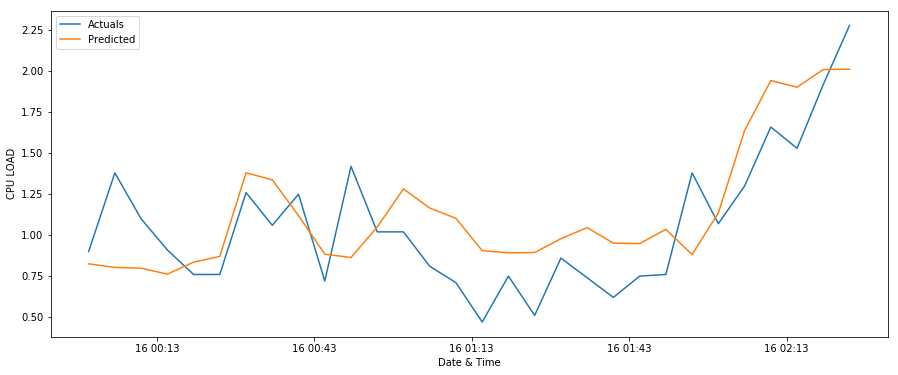

In [4]:
if __name__ == "__main__":
    # calling main function
    main()